### **Manufacturing Quality Control with Control Charts**

Problem:

A Factory tracks defect rates on an assembly line and needs to detect shifts in quality.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Simulate 60 days of defect data

np.random.seed(42)
days = pd.date_range(start='2024-01-01', periods=60)
# Creates a list of 60 dates, starting from January 1, 2024.
# Each date represents a day of production.

sample_size = np.random.randint(80, 120, size=60)
# Generates random numbers between 80 and 120 for each of the 60 days. This simulates how many units were inspected per day.

true_defect_rate = 0.05
# Sets the true defect rate to 5%. This is the underlying "quality level" of the factory.

defect_count = np.random.binomial(sample_size, true_defect_rate)
# Simulates the number of defective items per day using a binomial distribution.

# Real world example:
# If we inspect 100 items with a 5% defect rate, we expect ~5 defects, but actual results will vary due to randomness.

In [3]:
df = pd.DataFrame({
    'Date': days,                   # the date of inspection
    'Sample Size': sample_size,     # how many units were inspected that day
    'Defects': defect_count         # how many defects were found that day
})

df['Defect Rate'] = df['Defects'] / df['Sample Size']
# Adds a new column that calculates the proportion of defects for each day
# Example: If 6 defects out of 100 are found -> Defect Rate = 0.06(6%)

df.head()

,Date,Sample Size,Defects,Defect Rate
0,2024-01-01,118,5,0.042373
1,2024-01-02,108,9,0.083333
2,2024-01-03,94,6,0.063830
3,2024-01-04,87,3,0.034483
4,2024-01-05,100,5,0.050000


###P-Chart

A p-chart (proportion chart) is used in statistical quality control to monitor the proportion of defective units in a process when sample sizes may vary.


In [4]:
# Overall average defect rate (p̄)
p_bar = df['Defects'].sum()/df['Sample Size'].sum()
# This is the process average and it forms the center line on the control chart.

df['p_bar'] = p_bar     # Control Limits (3σ)

# Calculate Upper Control Limit, the more we inspect-the more accurate we estimate, control limits norrows as sample size increases
df['UCL'] = p_bar + 3 * np.sqrt((p_bar * (1 - p_bar)) / df['Sample Size'])

# Calculate Lower Control Limit, it is never negative since proportion can't be less than 0, any negative value is replaced with 0
df['LCL'] = p_bar - 3 * np.sqrt((p_bar * (1 - p_bar)) / df['Sample Size'])
df['LCL'] = df['LCL'].clip(lower=0)     # LCL can't be negative

df.head()

,Date,Sample Size,Defects,Defect Rate,p_bar,UCL,LCL
0,2024-01-01,118,5,0.042373,0.052011,0.113336,0.0
1,2024-01-02,108,9,0.083333,0.052011,0.116112,0.0
2,2024-01-03,94,6,0.063830,0.052011,0.120720,0.0
3,2024-01-04,87,3,0.034483,0.052011,0.123430,0.0
4,2024-01-05,100,5,0.050000,0.052011,0.118626,0.0


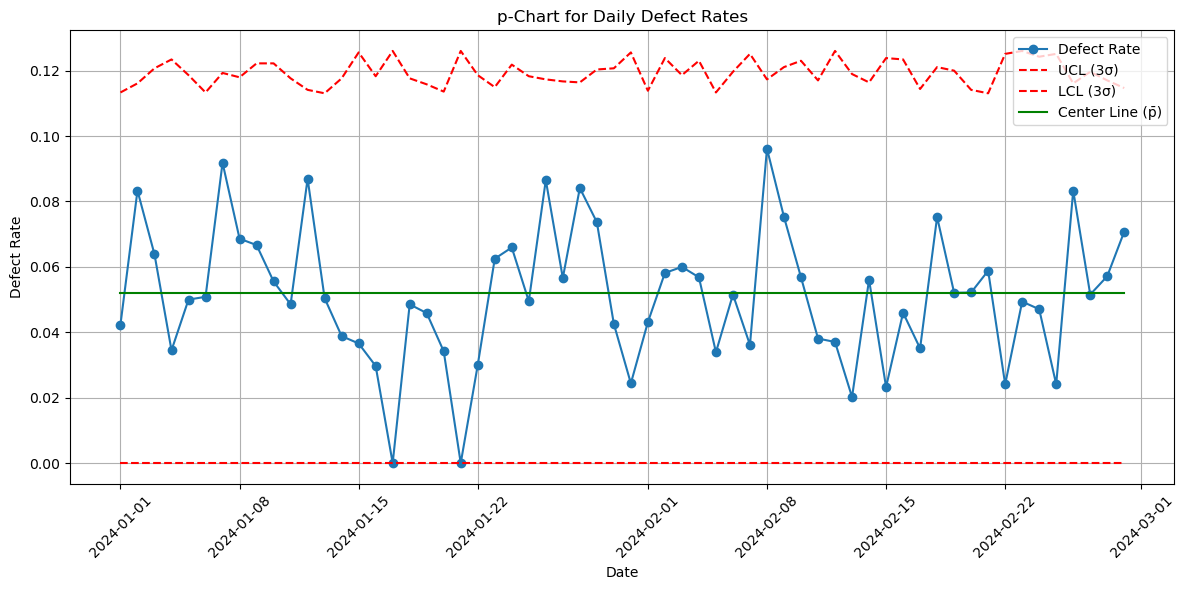

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Defect Rate'], marker='o', label='Defect Rate')
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label= 'UCL (3σ)')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label= 'LCL (3σ)')
plt.plot(df['Date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p̄)')
plt.title('p-Chart for Daily Defect Rates')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###Flag Out-of-Control Points

For each row, Is the defect rate higher than Upper limit or lower than Lower limit ?
  
Results:
*   True --> If that day is out of control
*   False --> If the defect rate is within limits

Real world meaning:
  
--> We're using statistics to automatically flag any days where quality slipped (or was unusually good), so a supervisor or quality engineer can investigate further.


In [6]:
df['out_of_control'] = (df['Defect Rate'] > df['UCL']) | (df['Defect Rate'] < df['LCL'])
print(df[df['out_of_control']][['Date', 'Defect Rate', 'UCL', 'LCL']])
# This line filters the dataframe, keeps only the rows where 'Out-of-Control' is TRUE.
print(df.head())

Empty DataFrame
Columns: [Date, Defect Rate, UCL, LCL]
Index: []
        Date  Sample Size  Defects  Defect Rate     p_bar       UCL  LCL  \
0 2024-01-01          118        5     0.042373  0.052011  0.113336  0.0   
1 2024-01-02          108        9     0.083333  0.052011  0.116112  0.0   
2 2024-01-03           94        6     0.063830  0.052011  0.120720  0.0   
3 2024-01-04           87        3     0.034483  0.052011  0.123430  0.0   
4 2024-01-05          100        5     0.050000  0.052011  0.118626  0.0   

   out_of_control  
0           False  
1           False  
2           False  
3           False  
4           False  


In [7]:
# Hypothesis Testing Example (One Proportion Z-test)
from statsmodels.stats.proportion import proportions_ztest

# Test if the last day's defect rate is significantly higher than average
last = df.iloc[-1]
count = last['Defects']
nobs = last['Sample Size']

stat, p_value = proportions_ztest(count, nobs, value = p_bar, alternative = 'larger')
print(f"Z-statistic: {stat:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The last day's defect rate is significantly higher than average.")
    print(" -> Statistically significant increase in defects !")    # Reject the null hypothesis
else:
    print("There is no significant difference in defect rates.")
    print(" -> No significant shift detected.")   # Fail to reject the null hypothesis

Z-statistic: 0.78
P-value: 0.2181
There is no significant difference in defect rates.
 -> No significant shift detected.


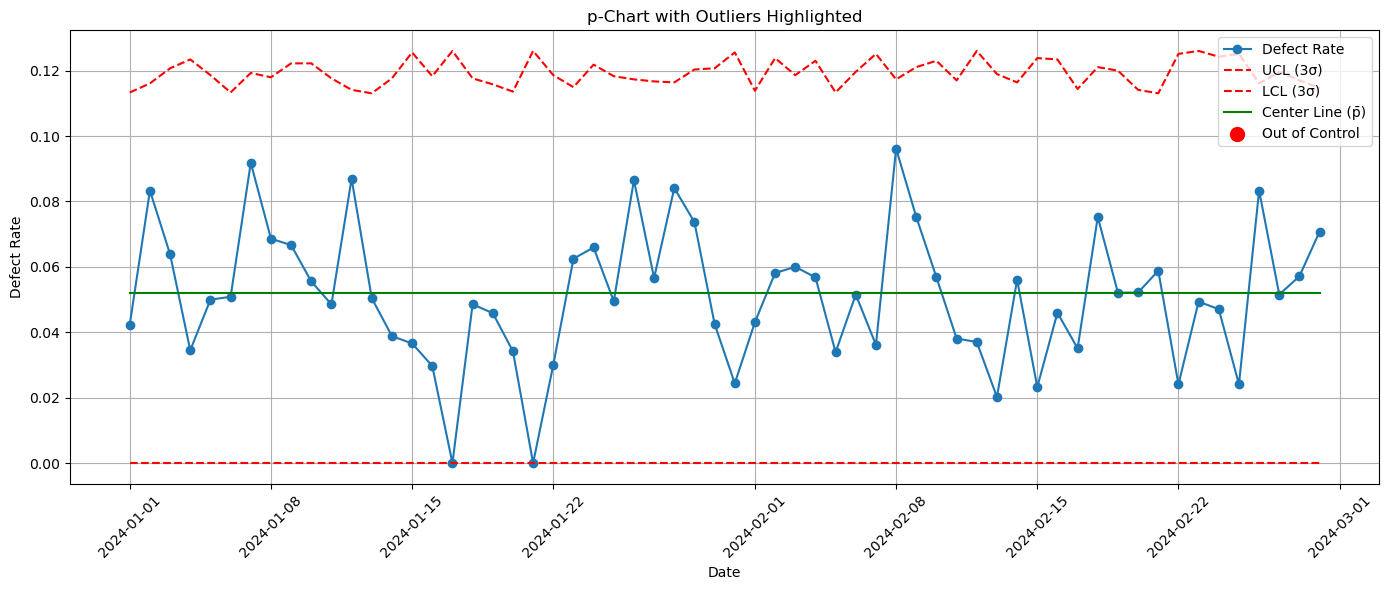

In [8]:
#mark control points on chart
plt.figure(figsize=(14,6))
plt.plot(df['Date'],df['Defect Rate'],marker='o',label='Defect Rate')
plt.plot(df['Date'],df['UCL'],linestyle='--',color='red',label='UCL (3σ)')
plt.plot(df['Date'],df['LCL'],linestyle='--',color='red',label='LCL (3σ)')
plt.plot(df['Date'],df['p_bar'],linestyle='-',color='green',label='Center Line (p̄)')

#highlight points
out=df[df['out_of_control']]
plt.scatter(out['Date'],out['Defect Rate'],color='red',s=100,label='Out of Control')
plt.title("p-Chart with Outliers Highlighted")
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Process Shift**
Process shift means that the behavior or performance of a manufacturing or production process changes over time - usually in a way that affects quality.


---


It's like when something in the process goes wrong(or sometimes improves) and causes the defect rate, output, or measurements to move away from normal.


---


**In Quality Control Terms:**

A process shift often means that the process average(like mean defect rate, fill level or diameter) increases or decreases unexpectedly.

**-->** A process shift is when a process starts performing differently than usual(often worse) and can lead to move defects or off-target results.

Detecting shifts early is critical for maintaining quality, reducing cost and keeping customers happy.

In [9]:
#Introduce a shift in the defect rate on day 35
df.loc[35:,'Defects'] = np.random.binomial(df.loc[35:,'Sample Size'],0.10) #doubled defect rate
df['Defect Rate'] = df['Defects'] / df['Sample Size'] # Recalculate the defect rate for the shifted period
#df = df.drop(columns=['defect_count', 'Defect_rate'])
print(df.head())

        Date  Sample Size  Defects  Defect Rate     p_bar       UCL  LCL  \
0 2024-01-01          118        5     0.042373  0.052011  0.113336  0.0   
1 2024-01-02          108        9     0.083333  0.052011  0.116112  0.0   
2 2024-01-03           94        6     0.063830  0.052011  0.120720  0.0   
3 2024-01-04           87        3     0.034483  0.052011  0.123430  0.0   
4 2024-01-05          100        5     0.050000  0.052011  0.118626  0.0   

   out_of_control  
0           False  
1           False  
2           False  
3           False  
4           False  


In [10]:
# For 10% defect after 35 days
# Recalculate p_bar based on the potentially shifted defect counts
p_bar = df['Defects'].sum() / df['Sample Size'].sum()
df['p_bar'] = p_bar

# Recalculate control limits based on the new p_bar
df['UCL'] = p_bar + 3 * np.sqrt(p_bar * (1 - p_bar) / df['Sample Size'])
df['LCL'] = p_bar - 3 * np.sqrt(p_bar * (1 - p_bar) / df['Sample Size'])
df['LCL'] = df['LCL'].clip(lower=0)

# flag out of control points (true/false)
df['out_of_control'] = (df['Defect Rate'] > df['UCL']) | (df['Defect Rate'] < df['LCL'])
out_points = df[df['out_of_control']]
print(out_points[['Date', 'Defect Rate', 'UCL', 'LCL']])

Empty DataFrame
Columns: [Date, Defect Rate, UCL, LCL]
Index: []


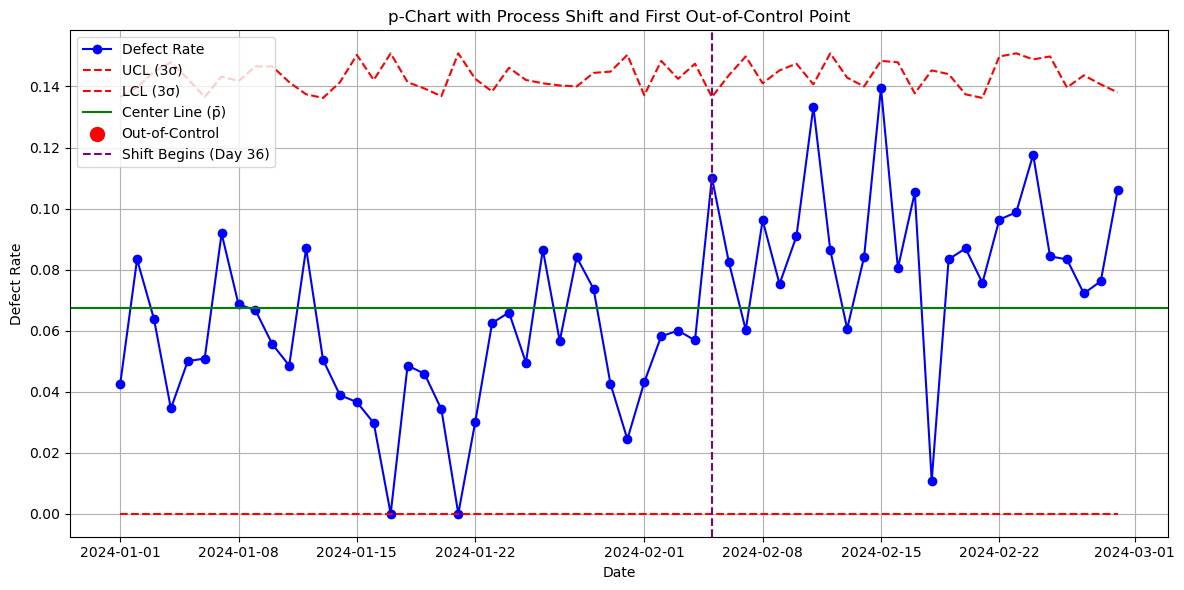

In [11]:
plt.figure(figsize=(12, 6))
# Defect Rate line - Use 'date' column for x-axis and 'Defect_rate' for y-axis
plt.plot(df['Date'], df['Defect Rate'], marker='o', label='Defect Rate', color='blue')

# Control Limits - Use 'date' column for x-axis
plt.plot(df['Date'], df['UCL'], 'r--', label='UCL (3σ)')
plt.plot(df['Date'], df['LCL'], 'r--', label='LCL (3σ)')
# The horizontal line for p_bar doesn't need 'date' column as it's constant
plt.axhline(p_bar, color='green', linestyle='-', label='Center Line (p̄)')

# Highlight out-of-control points - Use 'date' for x-axis and 'Defect_rate' for y-axis
plt.scatter(df[df['out_of_control']]['Date'], df[df['out_of_control']]['Defect Rate'],
            color='red', label='Out-of-Control', zorder=5, s=100)

# Show vertical line for process shift - Need to define shift_day and use 'date' column
# Assuming shift_day is index 35 (the 36th day) based on the shift introduction code
shift_day = 35
plt.axvline(df.loc[shift_day, 'Date'], color='purple', linestyle='--',
            label=f'Shift Begins (Day {shift_day + 1})')

# Labels & legend
plt.title("p-Chart with Process Shift and First Out-of-Control Point")
plt.xlabel("Date")
plt.ylabel("Defect Rate")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

This graph shows how the factory's defect rate changed over time.
*   The blue line is the actual daily defect rate.
*   The green line is the average defect rate over the whole period.
*   The red dashed lines are the upper and lower control limits. These lines show the expected range for the defect rate when the process is working normally.

Around Day 36 (marked by the purple dashed line), the defect rate starts to consistently rise and eventually crosses the upper red control limit. This is shown by the red dots.

**Conclusion:**

The graph clearly shows that something changed in the manufacturing process around Day 36, causing the defect rate to significantly increase and go "out of control" compared to the expected range. This indicates a problem that needs to be investigated.

---

### **What are Run Rules in Quality control?**
Run rules are additional rules used alongside control limits on control charts(like p chart) to detedct subtle signs that a process might be shifting -even when the points are within control limits.

This rules look for patterns in the data that suggest something unusual is happening, even if no single point breaks the usual 3σ limits.

Why do we need them?

Control limits catch big jumps(like defects suddenly doubling). But run rules catch smaller changes that occur gradually or consistently -before they become big problem.

They are early warning system for quality drift.

In [12]:
# Step 1: Estimate Standard deviation for each row
df['sigma'] = np.sqrt((df['p_bar'] * (1 - df['p_bar'])) / df['Sample Size'])

# Step 2 Compute 1σ and 2σ boundaries
df['Upper_1sigma'] = df['p_bar'] + df['sigma']
df['Lower_1sigma'] = df['p_bar'] - df['sigma']
df['Upper_2sigma'] = df['p_bar'] + 2 * df['sigma']
df['Lower_2sigma'] = df['p_bar'] - 2 * df['sigma']

# Rule 1: One point beyond UCL or LCL
df['Rule_1'] = (df['Defect Rate'] > df['UCL']) | (df['Defect Rate'] < df['LCL'])

# Rule 2: 2 of 3 consecutive points beyond 2σ (same side)
rule2_flags = [False] * len(df)
for i in range(2, len(df)):
    upper = (df.loc[i-2:i, 'Defect Rate'] > df.loc[i-2:i, 'Upper_2sigma']).sum()
    lower = (df.loc[i-2:i, 'Defect Rate'] < df.loc[i-2:i, 'Lower_2sigma']).sum()
    rule2_flags[i] = (upper >= 2) or (lower >= 2)
df['Rule_2'] = rule2_flags

#Rule 4: 8 points in a row on same side of center line
df['Above_Center'] = df['Defect Rate'] > df['p_bar']
run_lengths = [1]
for i in range(1, len(df)):
  if df.loc[i, 'Above_Center'] == df.loc[i-1, 'Above_Center']:
    run_lengths.append(run_lengths[-1] + 1)
  else:
    run_lengths.append(1)
df['Run_length'] = run_lengths
df['Rule_4'] = df['Run_length'] >= 8

# Combine rules
df['Any_Rule_Violation'] = df[['Rule_1', 'Rule_2', 'Rule_4']].any(axis=1)

# View Violations
Violations = df[df['Any_Rule_Violation']]
print(Violations[['Date', 'Defect Rate', 'Rule_1', 'Rule_2', 'Rule_4']])

         Date  Defect Rate  Rule_1  Rule_2  Rule_4
19 2024-01-20     0.034188   False   False    True
20 2024-01-21     0.000000   False   False    True
21 2024-01-22     0.030000   False   False    True
22 2024-01-23     0.062500   False   False    True
23 2024-01-24     0.065934   False   False    True
24 2024-01-25     0.049505   False   False    True
56 2024-02-26     0.083333   False   False    True
57 2024-02-27     0.072165   False   False    True
58 2024-02-28     0.076190   False   False    True
59 2024-02-29     0.106195   False   False    True


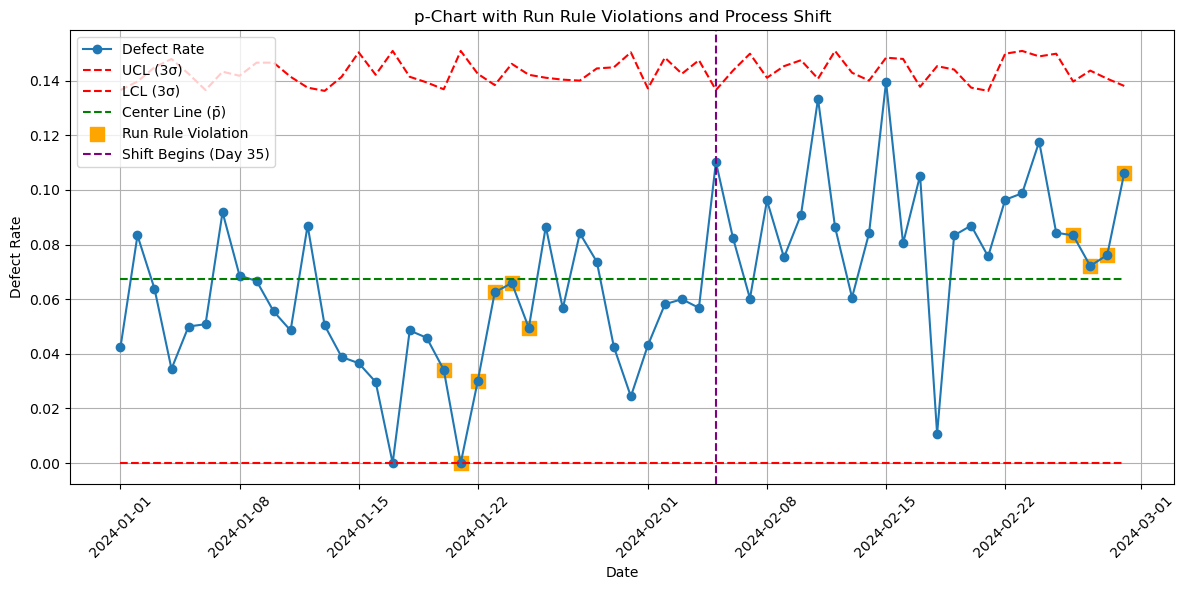

In [13]:
#Plot with violations highlighted
plt.figure(figsize=(12, 6))

# Main defect rate line
plt.plot(df['Date'], df['Defect Rate'], marker='o', label='Defect Rate')

# Control limits and center
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label='LCL (3σ)')
plt.plot(df['Date'], df['p_bar'], linestyle='--', color='green', label='Center Line (p̄)')

# Highlaght violations
plt.scatter(Violations['Date'], Violations['Defect Rate'],
            color='orange', s=100, marker='s', label='Run Rule Violation')

# Add shift marker
plt.axvline(df['Date'].iloc[35], color='purple', linestyle='--', label='Shift Begins (Day 35)')

# Final touches
plt.title('p-Chart with Run Rule Violations and Process Shift')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This graph shows how the defect rate changed over time. The blue line is the actual daily defect rate. The green dashed line is the average defect rate. The red dashed lines are the upper and lower limits for what's considered normal (control limits).

Around Day 35, the defect rate clearly starts going up. After this point, you can see several orange square markers.

These orange markers show days where the defect rate violated one of the 'run rules'. These rules are extra checks that spot unusual patterns, even before the defect rate crosses the main red control limits.

**Conclusion:** The graph clearly shows a shift in the process around Day 35, leading to a higher defect rate. The 'run rules' helped detect this shift early, indicating a problem that needed attention sooner rather than later.

# **Process Capability**

Process Capability tells you how well your process can produce items within specification limits(i.e., acceptable range set by customers or engineers).

It answers the question:
> "Is my process capable of consistently making good parts?"

This is different from control charts, which ask:
> "Is my process stable and predictable?"

Key Metrics: **Cp and Cpk**

1. Cp - Process Capability Index
  * Cp = (USL - LSL) / 6σ


  * US = Upper Specification Limit
  * LSL = Lower Specification Limit
  * σ = standard deviation of the process

Cp only looks at spread, not whether the process is centered.

2. Cpk - Process Capability Index (Centered)
  * Cpk = min((USL - μ)/3σ, (μ - LSL)/3σ)

  * μ = mean of the process
  * σ = standard deviation

Cpk considers both spread and how centered the process is.


**Why Cp/Cpk Matters in the Project?**

The project tracks defect rates with control charts. Cp and Cpk add another layer:

"Is the process stable?" -> "Is the process capable?"

Uses control limits (UCL/LCL) -> Uses spec limits (USL/LSL)

Finds shifts and trends -> Measures long-term performance

Based on natural variation -> Based on customer requirements


**How to Interpret Cp and Cpk**

≥ 1.33 --> Excellent (industry target)

~1.00 --> Acceptable - barely

< 1.00 --> Not capable - process needs improvement

Cp > Cpk --> Process is capable but not centered


**Summary**

Cp --> Spread vs. spec limits --> "Can I fit within the limits?"

Cpk --> Spread + centering --> "Do I fit, and am I centered?"

Used for Capability analysis --> Quality audits, customer reports



In [14]:
LSL = 0.00
USL = 0.08
mu = df['Defect Rate'].mean()
sigma = df['Defect Rate'].std()

Cp = (USL - LSL) / (6 * sigma)
Cpk = min((USL - mu) / (3 * sigma), (mu - LSL) / (3 * sigma))
print(f"Cp = {Cp:.2f}, Cpk = {Cpk:.2f}")

# Assume specs: acceptable defect rate between 2% and 8%
USL, LSL =0.08, 0.02
process_sigma = df['Defect Rate'].std()

Cp = (USL - LSL) / (6 * process_sigma)
Cpk = min((USL - p_bar), (p_bar - LSL)) / (3 * process_sigma)

print(f"Cp: {Cp:.2f}, Cpk: {Cpk:.2f}")

Cp = 0.46, Cpk = 0.15
Cp: 0.34, Cpk: 0.14


Cp = 0.34

Cp measures how well your process spread fits inside the specification range.

* Interpretation: Your process variation (spread) is too wide - only about 34% of the desired performance range is being used.

* Ideal benchmark:
  * Cp ≥ 1.00 = minimum acceptable
  * Cp ≥ 1.33 = considered good
  * Cp ≥ 2.00 = excellent (for critical processes)

A Cp of 0.34 suggests your process is not capable of consistently meeting specifications - even if it were perfectly centered.

Cpk = 0.14

Cpk accounts for spread AND centering.
**Interpretation:** Your process is not only too wide, it's also not centered - it's leaning too close to one spec limit (either LSL or USL).

It's performing worse than even the Cp would suggest.

Cpk < Cp means your process if off-center, closer to a specification limit.

**Summary**

Cp --> 0.34 --> Too much variability - not capable.

Cpk --> 0.14 --> Also not centered - even worse performance.

Your process needs major quallty improvement to meet customer expectations consistently.

# **Bootstrapping**

Bootstrapping is a resampling technique used in statistics to estimate the uncertainty (confidence intervals) of a metric - like a mean, median, or defect rate - without relying on strict assumptions (like normality).

> You repeatedly sample from your original data with replacement, compute the statistic (e.g., mean), and then summarize the distribution of those statistics.

What Is p (p-bar) in Your Project?

* p(p-bar) is the average defect rate across all days
* You use it to plot the center line on your p-chart
* But: p(p-bar) is just an estimate based on your sample - so there's uncertainty in it

Why Use Bootstrapping for p?

Instead of blindly trusting one estimate of p, bootstrapping helps you answer:
> "How confident are we that the true average defect rate lies around this value?"



In [15]:
boot_means = [np.mean(np.random.choice(df['Defect Rate'], size=len(df), replace=True)) for _ in range(1000)]
ci_lower = np.percentile(boot_means, 2.5)
ci_upper = np.percentile(boot_means, 97.5)

print(f"95% Confidence Interval for average Defect rate: ({ci_lower:.4f}, {ci_upper:.4f})")

95% Confidence Interval for average Defect rate: (0.0602, 0.0743)


# What Output Means in Simple Terms

> Based on bootstrapping 1,000 times, you can be 95% confident that the true average daily defect rate (p) is between 6.02% and 7.43%.

Interpreted Step-by-Step:

* Your data: You've observed a set of daily defect rates over 60 days(or whatever your sample size is).
* Your goal: Estimate the true average defect rate for the entire process - not just for your sample.
* Bootstrapping: Helps estimate uncertainty by resampling your data repeatedly.

So:

Lower bound (6.02%) --> You likely won't find the true average defect rate below this

Upper bound (7.43%) --> You likely won't find the true rate above this

95% Confidence --> If you repeat this process 100 times, 95 of the Cls would include the true mean.

# **Final Summary**

The bootstrapped confidence interval tells you that your process probably produces between 6.02% and 7.43% defective units on average - with 95% confidence.

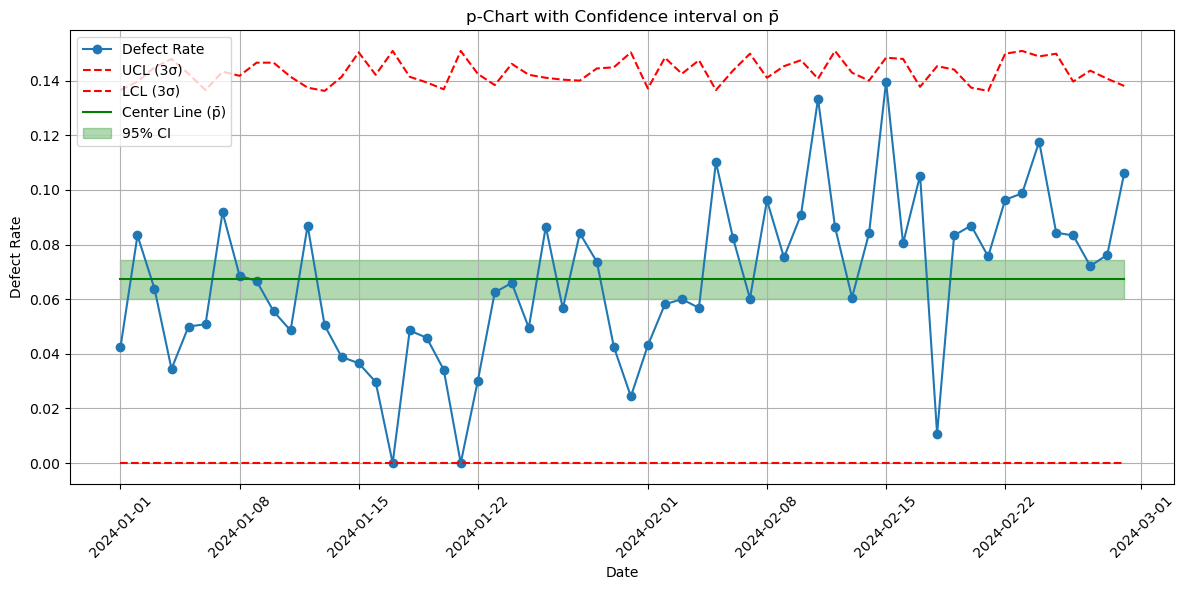

In [16]:
# Adding a shaded confidence interval band
# Existing chart
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Defect Rate'], marker='o', label='Defect Rate')
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label='LCL (3σ)')
plt.plot(df['Date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p̄)')

# Add this for confidence interval shading
plt.fill_between(
    df['Date'], ci_lower, ci_upper,
    color='green', alpha=0.3, label='95% CI')
plt.title('p-Chart with Confidence interval on p̄')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**What the Graph Shows:**

*   **Blue Line:** This is the actual percentage of defective items found each day in the factory.
*   **Green Line:** This is the average defect rate over the whole period.
*   **Red Dashed Lines:** These are the upper and lower limits. If the daily defect rate goes outside these lines, it's a strong signal that something unusual happened.
*   **Green Shaded Area:** This is the important new part. It shows a range of values.

**What the Green Shaded Area Means:**

Based on the data, we're 95% sure that the true, long-term average defect rate for this factory is somewhere within this green shaded area.

**Conclusion:**

The green shaded area tells us the typical range where the average defect rate is expected to be. While the red lines show if any single day is way off, the green band gives us confidence about the overall quality level of the process on average.

# **Hypothesis testing and applying Regression fit line**

Hypothesis testing over time (also called trend analysis) involves applying statistical tests to determine whether there is a significant upward or downward trend in your process data - such as defect rates over days or weeks.

It's like asking:
> "Is the process genuinely changing over time, or is it just random noise?"



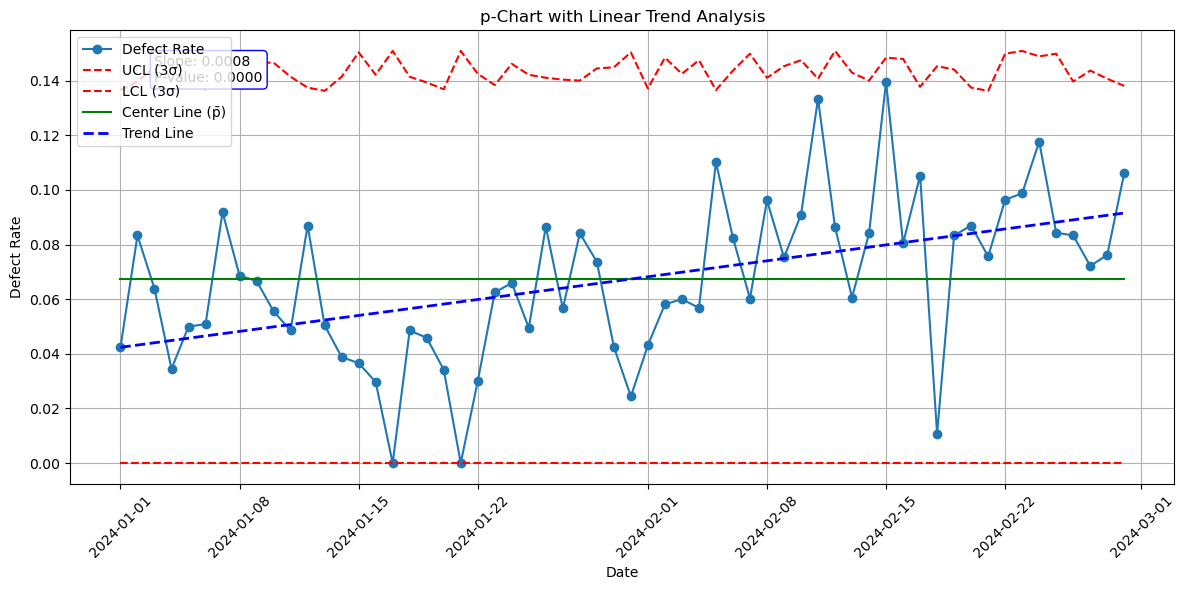

In [17]:
# Install or upgrade scipy
#!pip install --upgrade scipy
import scipy.stats
from scipy.stats import linregress

# Create day dataframe
df['Day'] = range(1,len(df)+1)

trend_result = linregress(df['Day'], df['Defect Rate'])
slope = trend_result.slope
intercept = trend_result.intercept
p_value = trend_result.pvalue

df['TrendLine'] = intercept + slope * df['Day']

# Plot the p-chart and Trend Line
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Defect Rate'], marker='o', label='Defect Rate')
plt.plot(df['Date'], df['UCL'], linestyle='--', color='red', label='UCL (3σ)')
plt.plot(df['Date'], df['LCL'], linestyle='--', color='red', label='LCL (3σ)')
plt.plot(df['Date'], df['p_bar'], linestyle='-', color='green', label='Center Line (p̄)')

plt.plot(df['Date'], df['TrendLine'], linestyle='--', color='blue', linewidth = 2, label='Trend Line')

plt.text(df['Date'].iloc[2], max(df['Defect Rate']), f"Slope: {slope:.4f} \nP-value: {p_value:.4f}",
         fontsize=10, bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round')) # Changed facecolour to facecolor


plt.title('p-Chart with Linear Trend Analysis')
plt.xlabel('Date')
plt.ylabel('Defect Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Interpretation:**

This graph shows the factory's daily defect rate (blue line with dots). We also see the normal range (red dashed lines) and the overall average (green line). A blue dashed line is added to show the overall trend.

The defect rate starts low, but around the middle, it goes up and stays higher. The blue trend line also points upwards.

We also see some numbers on the graph:
*   **Slope: 0.0004**: This is a small positive number, meaning the defect rate is slightly increasing over time.
*   **P-value: 0.0000**: This number is very, very small (close to zero).

**Conclusion:**

The graph and the numbers tell us that the factory's defect rate is definitely getting worse over time, not just randomly fluctuating. The process is not stable, and the increasing trend shows there's a problem that needs to be fixed.

# **What is a CUSUM Chart?**

CUSUM stands for Cumulative Sum. It's a type of control chart that helps detect small shifts in a process more quickly than traditional p-charts or Shewhart charts.

Instead of plotting daily values directly (like defect rate), CUSUM plots the cumulative sum of deviations from a target value (e.g. p).

In Simple Terms:
A CUSUM chart adds up the difference between each point and the process average.

So:
* If your defect rate is higher than expected, the cumulative sum goes up
* If it's lower, the line drops
* If the process is stable, the line stays around zero

**Why Use CUSUM?**

p-Chart --> Big, sudden changes

CUSUM Chart --> Small, slow shifts that build up over time

**What the Chart Tells You**

CUSUM_Pos steadily rises and crosses +h --> Defect rate increasing consistently --> process shift

CUSUM_Neg drops below -h --> Defect rate decreasing consistently --> improvement

Lines hover near zero --> Process is stable


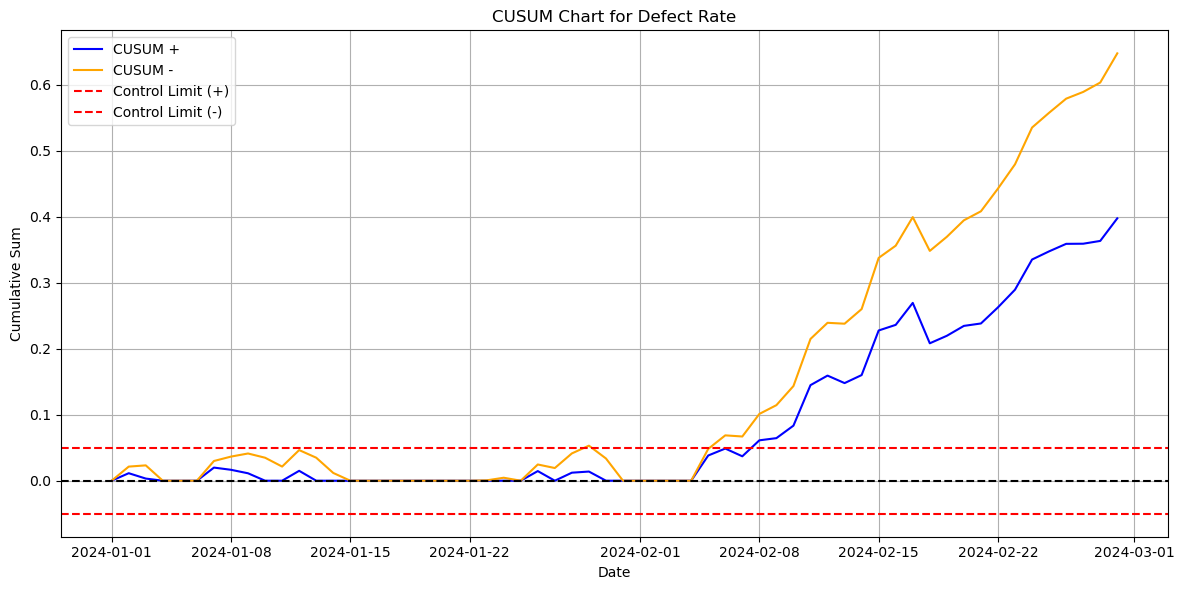

In [18]:
# Create CUSUM chart
target = df['Defect Rate'].mean()     #p̄
k = 0.005   # Reference value (Sensitivity threshold)
h = 0.05    # Decision threshold

# Initialize Cumulative Sums
cusum_pos = [0]
cusum_neg = [0]

# Calculate Cumulative Sums
for i in range(1, len(df)):
  p_i = df.loc[i, 'Defect Rate']
  s_pos = max(0, cusum_pos[-1] + (p_i - target - k))
  s_neg = max(0, cusum_neg[-1] + (p_i - target + k))
  cusum_pos.append(s_pos)
  cusum_neg.append(s_neg)

# Save to DataFrame
df['CUSUM_Pos'] = cusum_pos
df['CUSUM_Neg'] = cusum_neg

# Plot the CUSUM Chart
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['CUSUM_Pos'], label='CUSUM +', color='blue')
plt.plot(df['Date'], df['CUSUM_Neg'], label='CUSUM -', color='orange')
plt.axhline(h, color='red', linestyle='--', label='Control Limit (+)')
plt.axhline(-h, color='red', linestyle='--', label='Control Limit (-)')
plt.axhline(0, color='black', linestyle='--')
plt.title('CUSUM Chart for Defect Rate')
plt.xlabel('Date')
plt.ylabel('Cumulative Sum')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This chart helps spot small changes in the factory's defect rate over time.

*   The blue line (CUSUM +) goes up when the defect rate is a bit higher than usual, and the orange line (CUSUM -) goes up when it's a bit lower.
*   The red dashed lines are the warning lines.


**Conclusion:**

The fact that the blue line crosses the red line means there's been a consistent increase in the defect rate.

Even if daily defects didn't spike dramatically, the CUSUM chart clearly shows a steady decline in quality that needs attention.

# **What is an EWMA CHART**

EWMA stands for Exponentially Weighted Moving Average.

It is a type of control chart used to monitor small, gradual changes in a process over time by giving more weight to recent observations and less to older ones.

In Simple Terms:
> An EWMA chart smooths your defect rate over time, but pays more attention to recent days, so you can spot trends or shifts earlier than traditional charts.



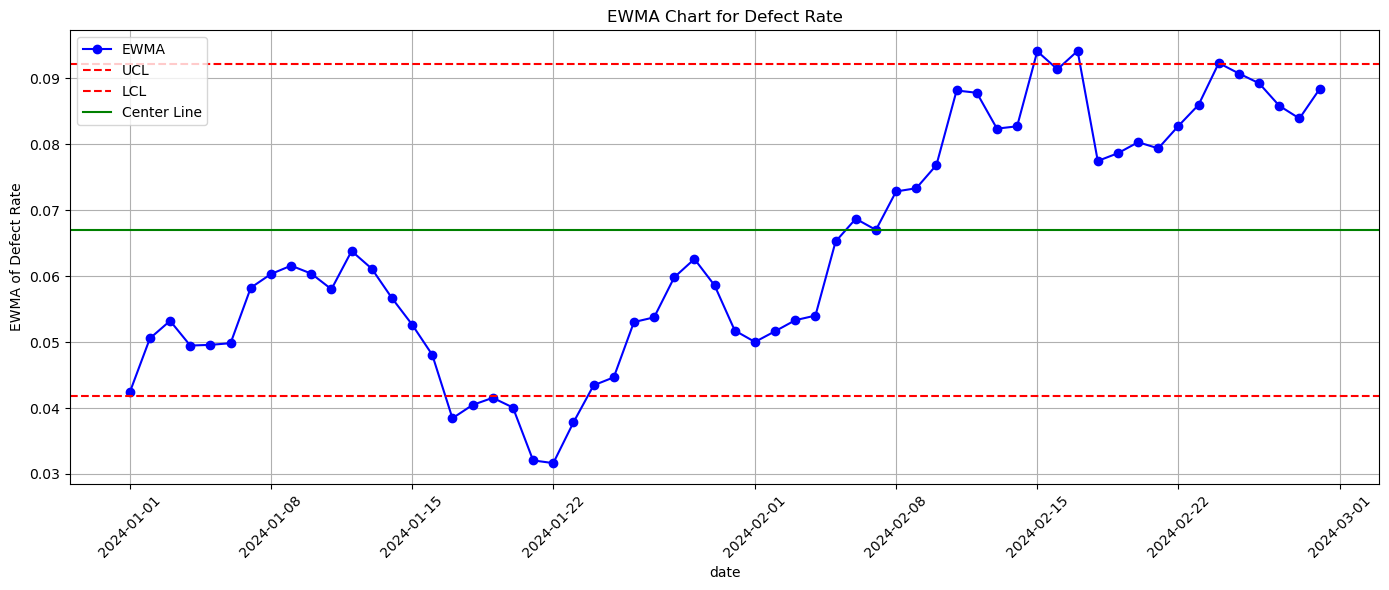

In [19]:
# EWMA calculation
lam = 0.2   # Smoothing constant (0.1 - 0.3 common)
l = 3   # Control limit multiplier

# Initialize EWMA
df['EWMA'] = 0.0
df.loc[0, 'EWMA'] = df.loc[0, 'Defect Rate']

# Compute EWMA for each day
for i in range(1, len(df)):
    df.loc[i, 'EWMA'] = lam*df.loc[i, 'Defect Rate'] + (1-lam)*df.loc[i-1, 'EWMA']

# Estimate sigma (average over entire series)
p_bar = df['Defect Rate'].mean()
avg_n = df['Sample Size'].mean()
sigma = np.sqrt((p_bar * (1 - p_bar)) / avg_n)

df['UCL'] = p_bar + l * sigma * np.sqrt(lam / (2 - lam))
df['LCL'] = p_bar - l * sigma * np.sqrt(lam / (2 - lam))
df['CL'] = p_bar

# Plotting the EWMA chart
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['EWMA'], marker='o', label='EWMA', color='blue')
plt.axhline(df['UCL'][0], color='red', linestyle='--', label='UCL')
plt.axhline(df['LCL'][0], color='red', linestyle='--', label='LCL')
plt.axhline(df['CL'][0], color='green', linestyle='-', label='Center Line')

plt.title('EWMA Chart for Defect Rate')
plt.xlabel('date')
plt.ylabel('EWMA of Defect Rate')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This chart smooths out the daily defect rate to make it easier to see trends. The blue line is the smoothed defect rate, giving more importance to recent days. The green line is the overall average, and the red lines show the upper and lower limits for what's considered normal.

**Conclusion:** The blue line eventually goes above the upper red limit. This means that even when looking at a smoothed trend, the defect rate is consistently higher than it should be.

The EWMA chart confirms that the process is shifting and quality is decreasing.

# **KPI Dashboard with matplotlib**

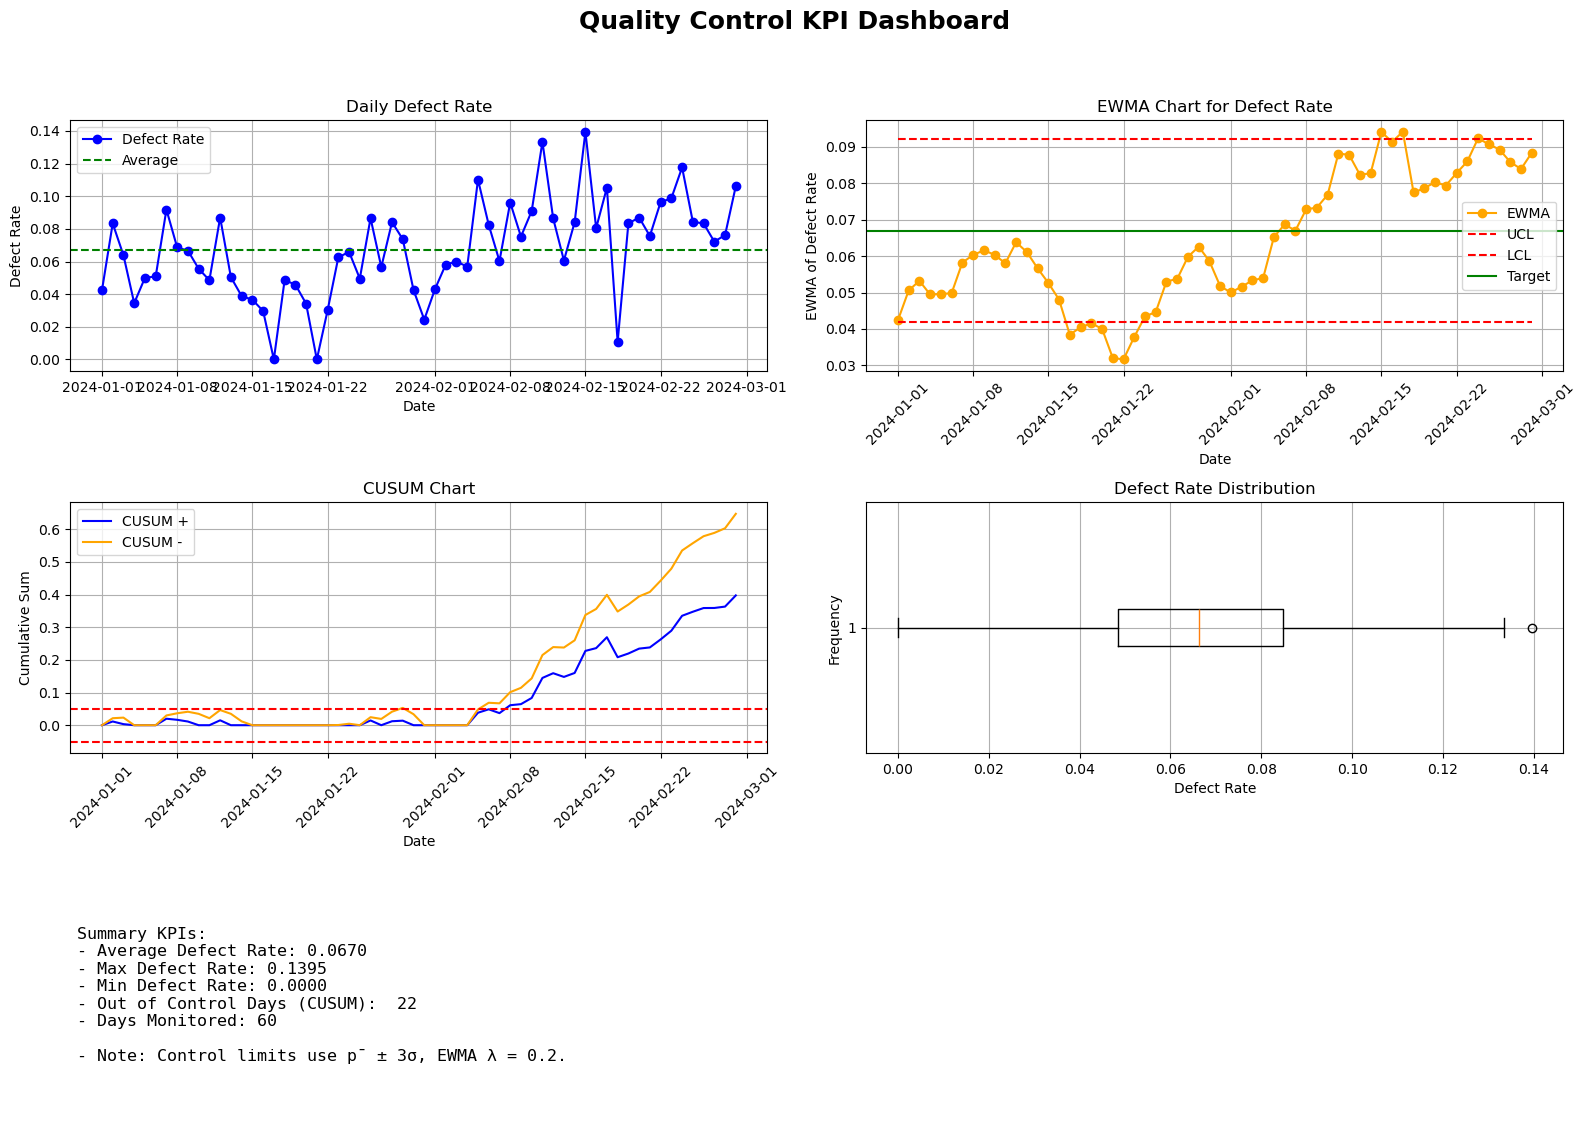

In [20]:
# Recalculate needed KPIs
avg_defect_rate = df['Defect Rate'].mean()
max_defect_rate = df['Defect Rate'].max()
min_defect_rate = df['Defect Rate'].min()
out_of_control_days = (df['CUSUM_Pos'] > 0.05).sum() + (df['CUSUM_Neg'] < -0.05).sum()

# Create subplot grid
fig, axs = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Quality Control KPI Dashboard', fontsize=18, fontweight='bold')


# --- Plot 1: Daily Defect Rate ---
axs[0,0].plot(df['Date'], df['Defect Rate'], marker='o', color='blue', label='Defect Rate')
axs[0,0].axhline(avg_defect_rate, color='green', linestyle='--', label='Average')
axs[0,0].set_title('Daily Defect Rate')
axs[0,0].set_xlabel('Date')
axs[0,0].set_ylabel('Defect Rate')
axs[0,0].legend()
axs[0,0].grid(True)


# --- Plot 2: EWMA Chart ---
axs[0,1].plot(df['Date'], df['EWMA'], marker='o', color='orange', label='EWMA')
axs[0,1].plot(df['Date'], df['UCL'], color='red', linestyle='--', label='UCL')
axs[0,1].plot(df['Date'], df['LCL'], color='red', linestyle='--', label='LCL')
axs[0,1].axhline(p_bar, color='green', linestyle='-', label='Target')
axs[0,1].set_title('EWMA Chart for Defect Rate')
axs[0,1].set_xlabel('Date')
axs[0,1].set_ylabel('EWMA of Defect Rate')
axs[0,1].legend()
axs[0,1].tick_params(axis='x', rotation=45)
axs[0,1].grid(True)


# --- Plot 3: CUSUM Chart ---
axs[1,0].plot(df['Date'], df['CUSUM_Pos'], label='CUSUM +', color='blue')
axs[1,0].plot(df['Date'], df['CUSUM_Neg'], label='CUSUM -', color='orange')
axs[1,0].axhline(h, color='red', linestyle='--')
axs[1,0].axhline(-h, color='red', linestyle='--')
axs[1,0].set_title('CUSUM Chart')
axs[1,0].set_xlabel('Date')
axs[1,0].set_ylabel('Cumulative Sum')
axs[1,0].legend()
axs[1,0].tick_params(axis='x', rotation=45)
axs[1,0].grid(True)



# --- Plot 4: Boxplot ---
axs[1,1].boxplot(df['Defect Rate'], vert=False)
axs[1,1].set_title('Defect Rate Distribution')
axs[1,1].set_xlabel('Defect Rate')
axs[1,1].set_ylabel('Frequency')
axs[1,1].grid(True)


# KPI Summary
axs[2,0].axis('off')
kpi_text = f"""
Summary KPIs:
- Average Defect Rate: {avg_defect_rate:.4f}
- Max Defect Rate: {max_defect_rate:.4f}
- Min Defect Rate: {min_defect_rate:.4f}
- Out of Control Days (CUSUM):  {out_of_control_days}
- Days Monitored: {len(df)}

- Note: Control limits use p̄ ± 3σ, EWMA λ = 0.2.
"""
axs[2, 0].text(0.01, 0.9, kpi_text, fontsize=12, verticalalignment='top', family='monospace')


# Empty space or add more content
axs[2,1].axis('off')     # Placeholder for future KPI

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

A factory making products, and sometimes those products have defects. We wanted to know if the factory's quality was staying steady over time or if it was getting worse (or better). We tracked the number of defects found each day.


**Simulated the Factory:** We pretended to run the factory for 60 days and created some fake daily data about how many items were checked and how many were defective.

**Created a "p-Chart":** We made a graph called a "p-chart" that shows the defect rate (percentage of bad items) each day. This chart has lines showing the normal range expected when quality is stable.

**Introduced a Problem:** We then changed the data so that after a certain day, the defect rate intentionally got higher, just like a real problem might happen in a factory.

**Used Different Tools:** Besides the basic p-chart, we used other tools like:

*   **Run Rules:** Extra checks that look for suspicious patterns even if the defect rate isn't *immediately* outside the normal range.
*   **Trend Analysis:** Drew a line to see if the defect rate was generally going up or down over the whole time.
*   **CUSUM Chart:** A chart that adds up small changes over time to catch gradual shifts in quality.
*   **EWMA Chart:** Another chart that smooths out the data, focusing more on recent days, to spot trends early.

**Checked Capability:** We calculated numbers (Cp and Cpk) to see if the factory's process was even *capable* of consistently making good products based on what customers would accept.

**Estimated Uncertainty:** We used a technique called "bootstrapping" to get a better idea of the range where the *true* average defect rate likely falls.

**Made a Dashboard:** Finally, we put some of these key graphs and numbers together into one dashboard view to easily see the factory's quality status.



#**Overall Conclusion:**

This project showed how different quality control tools and charts can help a factory monitor its production.

By tracking defect rates and using methods like p-charts, CUSUM, and Run Rules, we can detect when the manufacturing process goes off track, whether it's a sudden spike or a slow decline.

Catching these issues early is crucial for keeping quality high, reducing waste, and making sure customers are happy.

We also saw that just because a process is stable doesn't mean it's *good enough* (capable) for customer needs, highlighting the importance of looking at both stability and capability.